In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from indicators import get_sma
from evaluation import evaluate_strategy
from optimization import optimize_strategy_brute_force

In [ ]:
# define the strategy
def create_sma_cross_over_signal(data: pd.DataFrame, short_n: int, long_n: int) -> pd.DataFrame:
    strategy_df = pd.DataFrame(index=data.index)
    strategy_df["sma_short"] = get_sma(data, short_n)
    strategy_df["sma_long"] = get_sma(data, long_n)
    strategy_df.dropna(inplace=True)
    strategy_df["signal"] = np.where(strategy_df["sma_short"] > strategy_df["sma_long"], 1, -1)
    return strategy_df

In [12]:
data = pd.read_csv("data/USDEUR=X_20100101_20250801.csv", index_col=0, parse_dates=True)

# computing returns
data['returns_log'] = np.log(data['Close'] / data['Close'].shift(1))
data['returns_log'].dropna(inplace=True)

# Define in-sample and out-of-sample data
is_dates = ("2019-01-01", "2022-12-31")
oos_dates = ("2023-01-01", "2024-12-31")
data_is = data.loc[is_dates[0]:is_dates[1]].copy()
data_oos = data.loc[oos_dates[0]:oos_dates[1]].copy()

# Optimization
params_space = {
    "short_n": np.arange(5, 50, 3),
    "long_n": np.arange(60, 200, 3),
}

profit_factors = optimize_strategy_brute_force(data_is, create_sma_cross_over_signal, params_space)
for i, (k, v) in enumerate(profit_factors.items()):
    if i > 10:
        break
    print(f"Params: {k}, Profit Factor: {v}")

100%|██████████| 705/705 [00:01<00:00, 424.75it/s]

Params: (23, 60), Profit Factor: 1.1693146171508992
Params: (5, 141), Profit Factor: 1.147047682508472
Params: (5, 84), Profit Factor: 1.1468372783914627
Params: (5, 81), Profit Factor: 1.1465956347721384
Params: (23, 63), Profit Factor: 1.145886155390253
Params: (5, 117), Profit Factor: 1.142576782374479
Params: (5, 156), Profit Factor: 1.1401093260958899
Params: (5, 138), Profit Factor: 1.1393280757366768
Params: (5, 144), Profit Factor: 1.138122288615702
Params: (5, 159), Profit Factor: 1.1369822286902056
Params: (5, 120), Profit Factor: 1.1365638229257529


In [18]:
best_params = next(iter(profit_factors))
best_params

(23, 60)

Results for in-sample:
  Total Return: 28.69%
  Annualized Return: 6.80%
  Profit factor: 1.1693
  Number of trades: 34
Results for out-of-sample:
  Total Return: -8.34%
  Annualized Return: -4.64%
  Profit factor: 0.8875
  Number of trades: 24


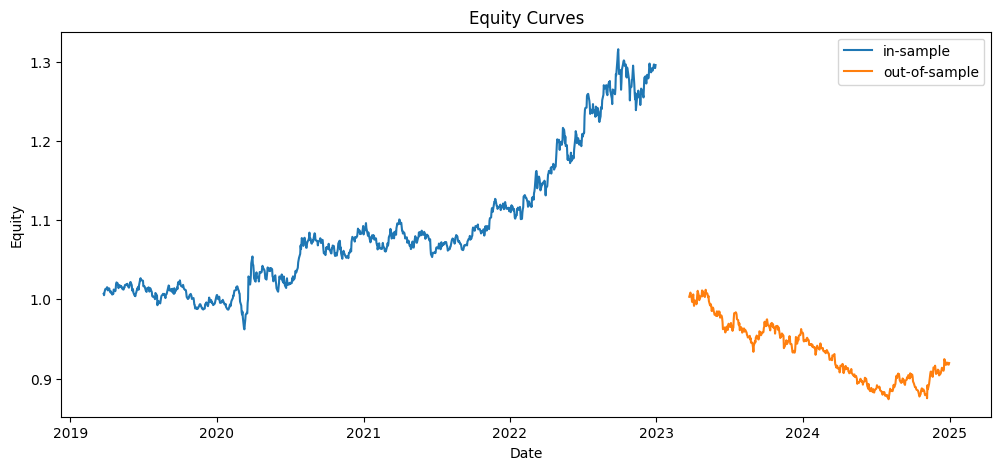

In [19]:
best_params = next(iter(profit_factors))
sma_short, sma_long = best_params[0], best_params[1]

data_evaluation = {
    "in-sample": data_is,
    "out-of-sample": data_oos
}
equity_curves = {}
for key, data_temp in data_evaluation.items():
    strategy = create_sma_cross_over_signal(data_temp, sma_short, sma_long)
    returns_strategy = data_temp.loc[strategy.index, 'returns_log'] * strategy['signal']
    print(f"Results for {key}:")
    results = evaluate_strategy(strategy['signal'], returns_strategy)
    print(20 * "=")
    equity_curves[key] = results['equity_curve']

fig, ax = plt.subplots(figsize=(12, 5))
for key, equity_curve in equity_curves.items():
    ax.plot(equity_curve, label=f"{key}")
ax.set_title("Equity Curves")
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
ax.legend()
plt.show()